In [1]:
import netCDF4
from tifffile import imsave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

ModuleNotFoundError: No module named 'gap_statistic'

In [4]:
# Import Sentinel 3

f = netCDF4.Dataset('/home/gsilsbe/Documents/Grants/NASADolphin/S3A_OLCI_EFR.20180710T151506_L2_OC_reprojected.nc', "r+", format="NETCDF4")

# Read in Variables and Convert to Numpy Arrays using [:]
Rrs_400 = f.variables['Rrs_400'][:] 
Rrs_412 = f.variables['Rrs_412'][:] 
Rrs_442 = f.variables['Rrs_442'][:]  
Rrs_490 = f.variables['Rrs_490'][:]  
Rrs_510 = f.variables['Rrs_510'][:]  
Rrs_560 = f.variables['Rrs_560'][:]  
Rrs_620 = f.variables['Rrs_400'][:]  
Rrs_665 = f.variables['Rrs_665'][:]  
Rrs_674 = f.variables['Rrs_674'][:]  
Rrs_681 = f.variables['Rrs_681'][:]  
Rrs_709 = f.variables['Rrs_709'][:]  


In [5]:
# Flatten Arrays and combine into single array ('pixel' x wavelength)

Rrs = np.vstack((Rrs_400.flatten(), Rrs_412.flatten(), Rrs_442.flatten(),
                 Rrs_490.flatten(), Rrs_510.flatten(), Rrs_560.flatten(),
                 Rrs_620.flatten(), Rrs_665.flatten(), Rrs_674.flatten(),
                 Rrs_681.flatten(), Rrs_709.flatten())).T

# Find rows with complete Rrs data 
ind = np.argwhere(~np.isnan(Rrs).any(axis=1)).flatten()

# Keep only rows where this is RRs data
Rrs = Rrs[ind]

# Normalize spectra (equal area using trapeziod integration)
# Not tested
wv = np.array([400, 412, 442, 490, 510, 560, 620, 665, 674, 681, 709])
trapz = np.trapz(Rrs, x=wv, axis=1)

# Rrs_norm = Rrs / trapz

print(len(ind))
print(trapz.shape)

Rrs_norm = normalize(Rrs, axis=1)

print(Rrs_norm.shape)
print(Rrs_norm)



223634
(223634,)
(223634, 11)
[[0.31465822 0.2811025  0.29013804 ... 0.2611001  0.26627314 0.2582722 ]
 [0.31465822 0.2811025  0.29013804 ... 0.2611001  0.26627314 0.2582722 ]
 [0.32319045 0.28334072 0.28977153 ... 0.2563877  0.2575122  0.24377212]
 ...
 [0.5006822  0.40594655 0.37200698 ... 0.04618733 0.04065371 0.02523335]
 [0.5055699  0.3960057  0.36198804 ... 0.04774027 0.0424679  0.02961198]
 [0.5055699  0.3960057  0.36198804 ... 0.04774027 0.0424679  0.02961198]]


In [6]:
optimalK = OptimalK(parallel_backend='rust')
optimalK

OptimalK(n_jobs=16, parallel_backend="rust")

In [7]:
n_clusters = optimalK(Rrs_norm, cluster_array=np.arange(6, 13))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  11


In [10]:
optimalK.gap_df

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,6.0,3.315177,55240.230732,18.791771,0.000416,63785.926627,0.000690,63784.697208
1,7.0,3.314976,55232.277619,22.062541,0.000489,63776.744095,0.001374,63770.921569
2,8.0,3.314306,55194.616708,31.749556,0.000704,63733.260658,0.000299,63736.206250
3,9.0,3.314650,55213.664768,29.035270,0.000643,63755.254310,0.000270,63755.934158
4,10.0,3.315123,55218.046791,33.500488,0.000742,63760.316181,0.000173,63761.990689
5,11.0,3.315197,55228.915949,11.152326,0.000247,63772.859848,0.001853,63769.354523
6,12.0,3.314798,55206.068781,65.608596,0.001454,63746.507355,NaN,NaN


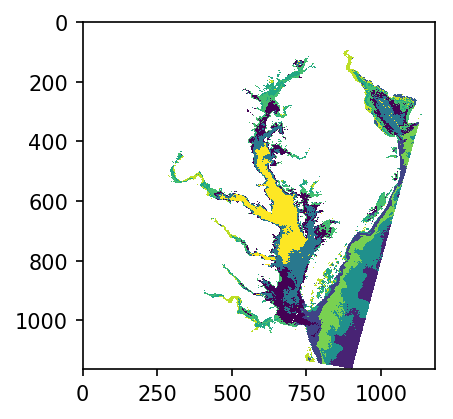

In [11]:
kmeans = KMeans(n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=100)
pred_y = kmeans.fit_predict(Rrs_norm)
# Rescale OWT classification into lon x lat

owt = np.empty(1377030)
owt[:] = np.nan
np.put(owt, ind, pred_y)
owt = owt.reshape((1165, 1182))

fig = plt.figure(figsize=(4.3, 2.9), dpi=150)
plt.imshow(owt)
fig.tight_layout()

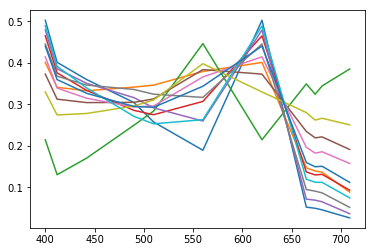

In [17]:
spectra = kmeans.cluster_centers_

plt.plot(wv, spectra[0,:])
plt.plot(wv, spectra[1,:])
plt.plot(wv, spectra[2,:])
plt.plot(wv, spectra[3,:])
plt.plot(wv, spectra[4,:])
plt.plot(wv, spectra[5,:])
plt.plot(wv, spectra[6,:])
plt.plot(wv, spectra[7,:])
plt.plot(wv, spectra[8,:])
plt.plot(wv, spectra[9,:])
plt.plot(wv, spectra[10,:])
plt.show()

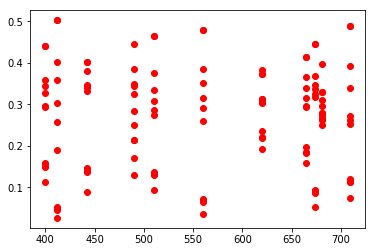